Model BouncingBall or DiscreteController

Based on: https://github.com/CATIA-Systems/FMPy/blob/master/fmpy/examples/custom_input.py

In [2]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result
from fmpy import *
import os
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import shutil
import json
import time as pytime
import datetime

In [ ]:
index = 0
# set number of simulation runs here
for s in range(5000):
    index = index + 1

    # start timing the simulation
    runtime_start = pytime.time()
    start_date = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    fmu_filename = 'DiscreteController.fmu'
    # extract the FMU
    unzipdir = extract(fmu_filename)

    # open and read json 
    print('Reading parameters JSON file...')
    with open('DiscreteController_pSets.json', 'r') as j:
        parameter_json_content = json.loads(j.read())
    print('Done')

    print('Reading inputs JSON file...')
    with open('DiscreteController_iSet.json', 'r') as j:
        input_json_content = json.loads(j.read())
    print('Done')



    # print out info about the fmu
    #dump(fmu_filename)
    model_description = read_model_description(fmu_filename)


    # collect the value references
    vrs = {}
    for variable in model_description.modelVariables:
        vrs[variable.name] = variable.valueReference
    # uncomment line below if you want to print out all inputs/parameters for the model and their value references
    #print('All parameters:', vrs)


    # check which inputs and parameters were given, then compare to the parameters gathered from the model
    vr_inputs = []
    input_names = []
    input_values = []
    parameter_names = []
    parameter_values = []
    output_names = []
    vr_parameters = []
    vr_outputs = []

    # get the value references for the variables we want to get/set, use the json files
    for key in parameter_json_content:
        if key in vrs:
            print('Found a parameter with name:', key)
            parameter_values.append(parameter_json_content[key])
            vr_parameters.append(vrs[key])
            parameter_names.append(key)

    # inputs
    for key in input_json_content:
        if key in vrs:
            print('Found an input with name:', key)
            input_values.append(input_json_content[key])
            vr_inputs.append(vrs[key])
            input_names.append(key)

    # getting outputs from the model description
    vr_outputs = []
    # https://github.com/CATIA-Systems/FMPy/blob/b76dfc85c9308a18f152fc80059cc97b8a86324b/fmpy/util.py#L664
    for v in model_description.modelVariables:
        if v.causality == 'output':
            vr_outputs.append(vrs[v.name])
            output_names.append(v.name)

    # fmu file is stored in /tmp
    print('FMU filename:', fmu_filename)


    # simulation parameters
    start_time = 0
    end_time = 10
    step_size = 0.01

    # check which FMU type
    # if it's not one FMU type then it must be the other
    try:    
        fmu = FMU2Slave(guid=model_description.guid,
            unzipDirectory=unzipdir,
            modelIdentifier=model_description.coSimulation.modelIdentifier,
            instanceName='instance1')
    except AttributeError:
        fmu = FMU2Slave(guid=model_description.guid,
            unzipDirectory=unzipdir,
            modelIdentifier=model_description.modelExchange.modelIdentifier,
            instanceName='instance1')
    except Exception:
        print("Error: could not initialize the FMU due to missing Linux binaries. Please see: https://github.com/CATIA-Systems/FMPy/issues/330")
        sys.exit()



    print("Initializing simulation...")
    # reset fmu
    fmu.instantiate()
    fmu.setupExperiment(startTime=start_time)
    fmu.enterInitializationMode()
    fmu.exitInitializationMode()
    print("Done")
    print("Running simulation...")
    time = start_time
    rows = []  # list to record the results

    # set initial value for outputs
    #fmu.setReal(vr_outputs, )

    # simulation loop
    while time < end_time:
    # NOTE: the FMU.get*() and FMU.set*() functions take lists of
    # value references as arguments and return lists of values
    #----------------- tweak the parameters here -----------------------
    # example: input is 0 until 0.9 seconds then becomes input_value
    # https://github.com/CATIA-Systems/FMPy/blob/b76dfc85c9308a18f152fc80059cc97b8a86324b/fmpy/fmi2.py#L314
        try:
            # set parameters
            fmu.setReal(vr_parameters, parameter_values)
            # set inputs
            fmu.setReal(vr_inputs, input_values)
        except:
            print("Error: failed to set custom inputs. This model may not allow parameters/inputs to be set.")
            # to catch "fmi2SetReal failed with status 3" error
            sys.exit()

        # perform one step in the simulation
        fmu.doStep(currentCommunicationPoint=time, communicationStepSize=step_size)

        # advance the time
        time += step_size

        # get the new values for 'inputs' and 'outputs' after advancing one step
        inputs  = fmu.getReal(vr_inputs)
        outputs = fmu.getReal(vr_outputs)

        # append the new data
        new_data = []
        new_data.append(time)
        if len(inputs) > 0:
            for i in inputs:
                new_data.append(i)
        # couldn't use zip because inputs and outputs not might be the same length and zip will only iterate through the smallest array
        # couldn't use concatenate because float is not iterable
        for i in parameter_values:
            new_data.append(i)
        for i in outputs:
            new_data.append(i)

        # append to rows for the output file
        rows.append(new_data)

        #### end of simulation loop ####

    # end simulation
    fmu.terminate()
    fmu.freeInstance()  
    print("Done")

    current_time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    result_filename = fmu_filename + "_" + str(current_time) + "_Results_Run" + str(index) + ".csv"

    # print a report showing total runtime, start date, end date, RTF (ratio of real time to simulated time)
    end_date = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    runtime = pytime.time() - runtime_start
    simulation_report_name = fmu_filename + "_" + str(start_date) +"_Report_Run" + str(index) + ".csv"
    print('Report name',simulation_report_name)
    # RTF = simulated time / real time
    rtf = (end_time - start_time) / (runtime)
    report_header = 'FMU file,Start date,End date,Simulation start time,Simulation end time,Total runtime,Real time factor (sim. time / real time)'
    report_contents = []
    report_contents.append([fmu_filename, str(start_date), str(end_date), str(start_time), str(end_time), str(runtime), str(rtf)])
        
    # save a report of the simulation run as CSV file 
    # comments = "" argument is so there's no # character at the beginning of the file
    np.savetxt(simulation_report_name, report_contents, delimiter=",", comments = "", fmt="%s", header = report_header)

    # creating a header for the CSV file
    csv_header = "time,"
    for i in input_names:
        csv_header = csv_header + i + ","
    for i in parameter_names:
        csv_header = csv_header + i + ","
    for i in output_names:
        csv_header = csv_header + i + ","
    csv_header = csv_header.rstrip(",")
        
    # uncomment lines below to write results to CSV files
    #print('Writing results to file...')
    #np.savetxt(result_filename, rows, delimiter=",", comments = "", fmt="%s", header = csv_header)

    

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_02_19_Report_Run19.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, '

Done
Report name DiscreteController.fmu_2022_07_16_20_02_20_Report_Run26.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_21_Report_Run33.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_21_Report_Run38.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_22_Report_Run43.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_02_22_Report_Run48.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, '

Done
Report name DiscreteController.fmu_2022_07_16_20_02_23_Report_Run54.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_24_Report_Run61.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_24_Report_Run67.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_25_Report_Run72.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_26_Report_Run89.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_28_Report_Run105.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_02_28_Report_Run110.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_31_Report_Run143.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.opar2': 7, 'Gain_2.opar1': 16, 'Gain_1.opar3': 6, 'Gain_1.opar2': 5, '

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_40_Report_Run238.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_02_41_Report_Run245.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_42_Report_Run255.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_02_42_Report_Run260.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_44_Report_Run284.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_49_Report_Run334.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_52_Report_Run368.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_02_53_Report_Run375.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_02_56_Report_Run415.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_01_Report_Run466.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_02_Report_Run483.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_03_Report_Run488.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.opar2': 7, 'Gain_2.opar1': 16, 'Gain_1.opar3': 6, 'Gain_1.opar2':

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_09_Report_Run562.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_11_Report_Run579.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_13_Report_Run595.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_14_Report_Run612.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_03_16_Report_Run628.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_17_Report_Run641.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_18_Report_Run652.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_18_Report_Run657.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_20_Report_Run676.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_23_Report_Run705.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_24_Report_Run721.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_31_Report_Run793.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_31_Report_Run798.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_32_Report_Run808.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_34_Report_Run829.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_35_Report_Run845.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_37_Report_Run861.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_37_Report_Run866.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_43_Report_Run928.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_43_Report_Run933.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_44_Report_Run938.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_46_Report_Run960.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_48_Report_Run980.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_49_Report_Run987.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Initializing simulation...
Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_03_49_Report_Run992.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)

Done
Report name DiscreteController.fmu_2022_07_16_20_03_50_Report_Run999.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6

Done
Report name DiscreteController.fmu_2022_07_16_20_03_50_Report_Run1006.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_55_Report_Run1059.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_03_57_Report_Run1082.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_04_27_Report_Run1400.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_04_27_Report_Run1410.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_28_Report_Run1421.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_04_29_Report_Run1426.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_04_30_Report_Run1436.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_04_33_Report_Run1467.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_36_Report_Run1506.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_37_Report_Run1517.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_04_38_Report_Run1527.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_04_39_Report_Run1532.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_40_Report_Run1543.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_04_40_Report_Run1548.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Done
Report name DiscreteController.fmu_2022_07_16_20_04_41_Report_Run1555.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_43_Report_Run1572.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_04_43_Report_Run1577.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_04_45_Report_Run1599.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_04_46_Report_Run1604.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_50_Report_Run1648.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_04_50_Report_Run1653.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_54_Report_Run1695.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_56_Report_Run1713.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_04_59_Report_Run1746.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_00_Report_Run1763.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_01_Report_Run1768.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_02_Report_Run1785.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_03_Report_Run1795.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_04_Report_Run1800.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_08_Report_Run1849.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_13_Report_Run1899.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_22_Report_Run1997.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_23_Report_Run2014.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_24_Report_Run2021.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_25_Report_Run2036.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_05_27_Report_Run2048.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_29_Report_Run2071.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_29_Report_Run2076.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_30_Report_Run2087.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_34_Report_Run2122.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_34_Report_Run2127.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_37_Report_Run2160.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_38_Report_Run2165.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_38_Report_Run2170.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_39_Report_Run2175.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_05_40_Report_Run2191.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_41_Report_Run2196.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_42_Report_Run2211.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_44_Report_Run2228.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_44_Report_Run2233.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_45_Report_Run2244.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_50_Report_Run2291.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_50_Report_Run2296.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_52_Report_Run2311.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_53_Report_Run2322.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_53_Report_Run2327.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_54_Report_Run2332.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_54_Report_Run2339.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_55_Report_Run2350.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_05_56_Report_Run2355.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_05_59_Report_Run2385.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_01_Report_Run2402.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_02_Report_Run2414.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_03_Report_Run2427.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_04_Report_Run2434.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_04_Report_Run2439.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_06_Report_Run2457.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_07_Report_Run2462.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_07_Report_Run2467.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_08_Report_Run2472.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_09_Report_Run2482.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_09_Report_Run2487.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_06_11_Report_Run2505.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_06_14_Report_Run2539.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_06_21_Report_Run2604.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Done
Report name DiscreteController.fmu_2022_07_16_20_06_21_Report_Run2610.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_24_Report_Run2633.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_27_Report_Run2665.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_27_Report_Run2670.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_06_28_Report_Run2675.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_29_Report_Run2686.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_29_Report_Run2691.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_30_Report_Run2696.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_06_31_Report_Run2706.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_06_33_Report_Run2726.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_06_33_Report_Run2732.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Done
Report name DiscreteController.fmu_2022_07_16_20_06_34_Report_Run2738.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_34_Report_Run2743.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_35_Report_Run2748.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_35_Report_Run2753.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_37_Report_Run2769.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_40_Report_Run2793.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_06_40_Report_Run2798.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Done
Report name DiscreteController.fmu_2022_07_16_20_06_41_Report_Run2805.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_41_Report_Run2810.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_42_Report_Run2815.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_06_43_Report_Run2827.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Done
Report name DiscreteController.fmu_2022_07_16_20_06_44_Report_Run2834.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_44_Report_Run2839.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_45_Report_Run2844.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_47_Report_Run2865.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_47_Report_Run2870.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_48_Report_Run2876.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_48_Report_Run2883.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_49_Report_Run2888.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_50_Report_Run2895.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_50_Report_Run2901.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_51_Report_Run2908.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_52_Report_Run2919.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_53_Report_Run2925.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_53_Report_Run2931.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_54_Report_Run2938.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_54_Report_Run2943.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_55_Report_Run2948.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_06_55_Report_Run2953.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.opar2': 7, 'Gain_2.opar1': 16, 'Gain_1.opar3': 6, 'Gain_1.opar2': 5, '

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_06_59_Report_Run2991.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_00_Report_Run2997.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_00_Report_Run3003.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_01_Report_Run3008.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_02_Report_Run3015.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_07_02_Report_Run3022.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Done
Report name DiscreteController.fmu_2022_07_16_20_07_03_Report_Run3028.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_03_Report_Run3033.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_04_Report_Run3038.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.opar2': 7, 'Gain_2.opar1': 16, 'Gain_1.opar3': 6, 'Gain_1.opar2': 5, '

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_07_08_Report_Run3079.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_07_09_Report_Run3089.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_10_Report_Run3095.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_11_Report_Run3100.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_11_Report_Run3105.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_11_Report_Run3110.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_07_12_Report_Run3115.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_07_14_Report_Run3136.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_07_16_Report_Run3152.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Running simulation...
Done
Report name DiscreteController.fmu_2022_07_16_20_07_16_Report_Run3158.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12,

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_07_19_Report_Run3181.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 

Done
Report name DiscreteController.fmu_2022_07_16_20_07_20_Report_Run3191.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

Done
Report name DiscreteController.fmu_2022_07_16_20_07_21_Report_Run3206.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Done
Report name DiscreteController.fmu_2022_07_16_20_07_22_Report_Run3211.csv
Writing results to file...
Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_

Reading parameters JSON file...
Done
Reading inputs JSON file...
Done
All parameters: {'Solver.Time_Tolerance': 2, 'Solver.Absolute_Tolerance': 1, 'Solver.Relative_Tolerance': 0, 'Ipar.(12,1)': 26, 'Ipar.(11,1)': 25, 'Ipar.(10,1)': 24, 'Ipar.(9,1)': 23, 'Ipar.(8,1)': 22, 'Ipar.(7,1)': 21, 'Ipar.(6,1)': 20, 'Ipar.(5,1)': 19, 'Ipar.(4,1)': 18, 'Ipar.(3,1)': 17, 'Ipar.(2,1)': 16, 'Ipar.(1,1)': 15, 'VssVirtualSampleClock1.offset': 29, 'VssVirtualSampleClock1.period': 28, 'VssVirtualSampleClock1.offsets': 14, 'VssVirtualSampleClock1.periods': 13, 'DiscrTransFunc.opar4': 27, 'DiscrTransFunc.opar3.(1,2)': 26, 'DiscrTransFunc.opar3.(1,1)': 25, 'DiscrTransFunc.opar2.(2,1)': 24, 'DiscrTransFunc.opar2.(1,1)': 23, 'DiscrTransFunc.opar1.(2,2)': 22, 'DiscrTransFunc.opar1.(1,2)': 21, 'DiscrTransFunc.opar1.(2,1)': 20, 'DiscrTransFunc.opar1.(1,1)': 19, 'Gain_6.opar3': 12, 'Gain_6.opar2': 11, 'Gain_6.opar1': 18, 'Gain_6_1.opar3': 10, 'Gain_6_1.opar2': 9, 'Gain_6_1.opar1': 17, 'Gain_2.opar3': 8, 'Gain_2.

### Plotting RTF

In [3]:
# get all the Bouncing ball report files in the current directory
csv_files = glob.glob("DiscreteController.fmu_*_Report_Run*.csv")
#print(csv_files)
df_list = (pd.read_csv(file) for file in csv_files)
# merge the CSVs into one large dataframe
big_df = pd.concat(df_list, ignore_index=True)

# truncating list to 100 length
#n = len(big_df) - 100
#big_df.drop(big_df.tail(n-0).index,
#        inplace = True)
#big_df.head(10)


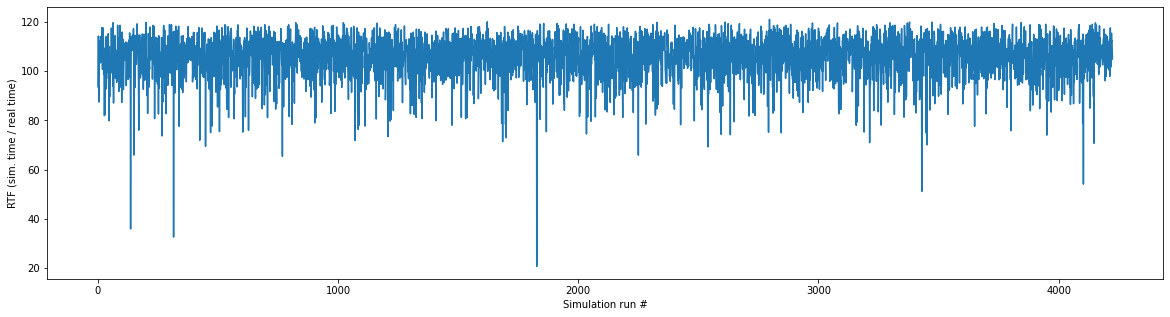

In [4]:
# plotting
# may go over 100 simulation runs due to additional csv files present from previous runs
rtf_array = big_df['Real time factor (sim. time / real time)']
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ax.plot(rtf_array)
ax.set_ylabel('RTF (sim. time / real time)')
ax.set_xlabel('Simulation run #')
plt.savefig('Local_RTF_Graph_DiscreteController_5kRuns.png')


# seem like some simulations run faster than others

In [ ]:
# find average RTF
sum_rtf = 0
for i in rtf_array:
    sum_rtf = sum_rtf + i
average_rtf = sum_rtf/len(rtf_array)
print('Average RTF for local machine runs:', average_rtf)